## NLP Class Final Project: Data Processing and LDA
### Isabella Xue

In [41]:
import pandas as pd
import re
from gensim import corpora, models
import gensim
import time
import re
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['font.family'] = 'serif'
sns.set_palette("pastel")

In [4]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/isabellaxue/nltk_data...
[nltk_data]    |   Pa

True

In [3]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [5]:
import multiprocessing

num_processors = multiprocessing.cpu_count()

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [6]:
%%time

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

CPU times: user 7.91 s, sys: 5.46 s, total: 13.4 s
Wall time: 39.7 s


(199208, 5)

In [11]:
df_news_final_project.head()

,url,date,language,title,text,combined_text
0,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Children With Autism Saw Their Learning and So...
1,http://thedailycougar.com/2021/11/24/college-o...,2021-11-24,en,College of Technology to launch AI Retail Lab ...,\nCollege of Technology to launch AI Retail L...,College of Technology to launch AI Retail Lab ...
2,http://www.desototimes.com/news/child-actor-cl...,2022-06-09,en,Child actor Claude Jarman Jr. looks back on hi...,\nChild actor Claude Jarman Jr. looks back on ...,Child actor Claude Jarman Jr. looks back on hi...
3,http://www.mysmartrend.com/news-briefs/technic...,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend...,\n\nCr Bard Inc Has Returned 48.9% Since SmarT...,Cr Bard Inc Has Returned 48.9% Since SmarTrend...
4,http://www.peripherals.consumerelectronicsnet....,2021-02-25,en,MulticoreWare Inc. Becomes CEVA’s Trusted Part...,\n\nMulticoreWare Inc. Becomes CEVA’s Trusted ...,MulticoreWare Inc. Becomes CEVA’s Trusted Part...


In [7]:
df_news_final_project.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199208 entries, 0 to 199207
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       199208 non-null  object
 1   date      199208 non-null  object
 2   language  199208 non-null  object
 3   title     199208 non-null  object
 4   text      199208 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [8]:
#check if all articles are in English
df_news_final_project['language'].value_counts()

language
en    199208
Name: count, dtype: int64

In [9]:
#Check If any Value is NaN in data
df_news_final_project.isnull().values.any()

False

In [11]:
df_news_final_project['date'] = pd.to_datetime(df_news_final_project['date'])

# Get the start and end dates
start_date = df_news_final_project['date'].min()
end_date = df_news_final_project['date'].max()

# Print the start and end dates
print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2020-01-01 00:00:00
End Date: 2023-07-15 00:00:00


In [49]:
# Extract the month and year from the 'date' column
df_news_final_project['month'] = df_news_final_project['date'].dt.to_period('M')

# Group by month and count the articles
articles_by_month = df_news_final_project.groupby('month').size().reset_index(name='article_count')


In [50]:
articles_by_month.head()

,month,article_count
0,2020-01,2562
1,2020-02,2272
2,2020-03,2616
3,2020-04,2550
4,2020-05,2495


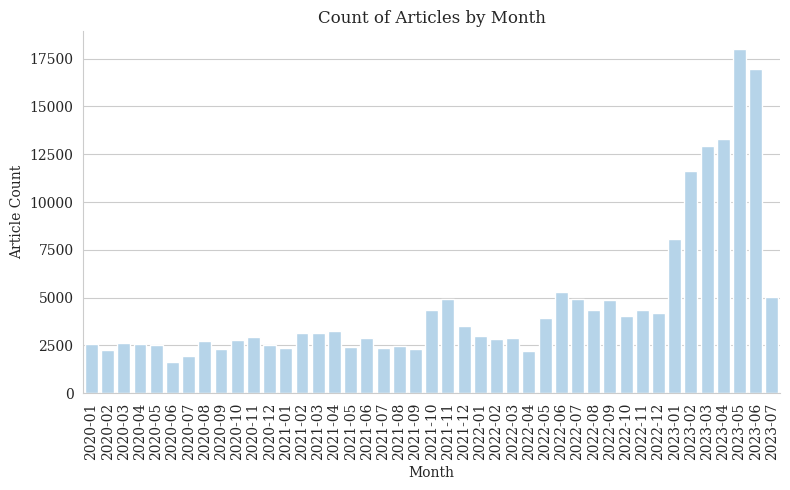

In [55]:
sns.set_palette("pastel")
bar_color = '#AED6F1'  # Soft blue color
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=articles_by_month, x='month', y='article_count', color=bar_color)
ax.set_title('Count of Articles by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Article Count')
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()

Outline:

**1. Data Preprocessing:**
- Remove noise like newlines, tabs, and other irrelevant text.
- Perform tokenization and stemming/lemmatization to standardize words.
- Remove irrelevant articles using techniques like keyword filtering.

**2. Detect Major Topics:**
- Apply topic modeling techniques like Latent Dirichlet Allocation (LDA) or BERTopic to identify major themes in the articles.

**3. Identify AI-Impacted Industries and Job Lines:**
- Utilize sentiment analysis to gauge the sentiment of articles towards AI in different industries.
- Use keyword matching or named entity recognition (NER) to identify industries and job lines being discussed.

**4. Identify AI Integration Candidates:**
- Apply sentiment analysis to determine positive/negative sentiments towards AI integration in specific industries and job lines.
- Consider industries where tasks are rule-based, repetitive, or data-driven, making them more suitable for automation.
- Use a timeline to visualize the changing sentiment over the years.

**5. Identify New AI Technologies and Solutions:**
- Employ NER to identify mentions of new AI technologies and solutions in the articles.
- Use keyword frequency analysis to understand the popularity and growth of these technologies over time.
- Create a timeline visualization to showcase the introduction of these technologies.

**6. Recommendations for Accelerating Development:**
- Suggest that companies invest in research and development in AI technologies.
- Encourage collaboration between academic institutions, companies, and government entities for knowledge sharing and resource allocation.

**7. Company Plans and Sentiment:**
- Extract organizations, people, and locations using NER.
- Perform targeted sentiment analysis on specific organizations' plans and sentiments towards AI adoption.
- Create visualizations like word clouds or bubble charts to summarize recommendations and sentiments.

**8. Applications Beyond AI's Current Reach:**
- Use sentiment analysis to identify areas where AI has not made significant progress due to limitations in technology.
- Visualize these findings using word clouds or bubble charts.

**Additional Guidance:**
- Experiment with various NLP techniques like topic modeling, classification, clustering, and zero-shot learning for better topic identification.
- Fine-tune sentiment analysis models using domain-specific data or lexicons.
- Consider combining techniques to enhance the accuracy of your insights.

### Data Preprocessing

In [10]:
# Combine 'title' and 'text' columns
df_news_final_project['combined_text'] = df_news_final_project['title'] + ' ' + df_news_final_project['text']

In [12]:
def clean_text(text):
    # Remove newlines, tabs, and other unwanted characters
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\t+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply text cleaning to combined_text
df_news_final_project['cleaned_text'] = df_news_final_project['combined_text'].apply(clean_text)

In [13]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenization 
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

# Lemmatization 
def lemmatize(token):
    return lemmatizer.lemmatize(token)

# Stopwords
stop_words = set(stopwords.words('english'))


In [14]:
# Function to perform lemmatization and keyword filtering
def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Apply lemmatization and keyword filtering
df_news_final_project['processed_text'] = df_news_final_project['cleaned_text'].apply(preprocess_text)


In [15]:
# Define relevant keywords for filtering
#keywords = ['data science', 'machine learning', 'artificial intelligence']
keywords = ['[Aa]rtificial [Ii]ntelligence',
        '[Mm]achine [Ll]earning',
        '[Dd]eep [Ll]earning',
        '[Nn]eural [Nn]etworks',
        '[Cc]onvolutional [Nn]eural [Nn]etworks',
        '[Rr]ecurrent [Nn]eural [Nn]etworks',
        '[Nn]atural [Ll]anguage [Pp]rocessing',
        '[Dd]ata [Mm]ining',
        '[Bb]ig [Dd]ata',
        '[Dd]ata [Ss]cience',
        '[Dd]ata [Aa]nalytics',
        '[Pp]redictive [Aa]nalytics',
        '[Mm]achine [Vv]ision',
        '[Ii]mage [Rr]ecognition',
        '[Oo]bject [Dd]etection',
        '[Ss]emantic [Ss]egmentation',
        '[Ee]motion [Rr]ecognition',
        '[Ff]acial [Rr]ecognition',
        '[Vv]oice [Rr]ecognition',
        '[Aa]utomated [Tt]esting',
        '[Aa]utomated [Rr]easoning',
        '[Kk]nowledge [Rr]epresentation',
        '[Rr]obotics',
        '[Aa]utonomous [Vv]ehicles',
        '[Cc]ognitive [Aa]rchitecture',
        '[Cc]omputational [Ii]ntelligence',
        '[Ss]warm [Ii]ntelligence',
        '[Ee]volutionary [Cc]omputation',
        '[Ff]uzzy [Ll]ogic',
        '[Aa]rtificial [Ll]ife',
        '[Gg]enetic [Aa]lgorithms',
        '[Nn]euroevolution',
        '[Nn]euroscience [Ii]nspired [Aa]rtificial [Ii]ntelligence',
        '[Aa]ugmented [Rr]eality',
        '[Vv]irtual [Rr]eality',
        '[Gg]enerative [Aa]dversarial [Nn]etworks',
        '[Tt]ransformer [Mm]odels',
        '[Bb]ayesian [Nn]etworks',
        '[Hh]idden [Mm]arkov [Mm]odels',
        '[Ss]upport [Vv]ector [Mm]achines',
        '[Ee]xtreme [Ll]earning [Mm]achines',
        '[Rr]einforcement [Ll]earning',
        '[Qq]-learning',
        '[Aa]dversarial [Ll]earning',
        '[Gg]radient [Dd]escent',
        '[Bb]ackpropagation',
        '[Oo]ptimization [Aa]lgorithms',
        '[Ll]ogistic [Rr]egression',
        '[Ss]entiment [Aa]nalysis',
        '[Ss]ocial [Nn]etwork [Aa]nalysis',
        '[Cc]omputer [Vv]ision',
        '[Ii]mage [Pp]rocessing',
        '[Ii]mage [Gg]eneration',
        '[Ii]mage [Cc]lassification',
        '[Ii]mage [Rr]ecognition',
        '[Cc]hat [Bb]ots',
        '[Nn]atural [Ll]anguage [Gg]eneration'
        '[Cc]hat GPT',
        '[Cc]onversational AI',
        'AI'
        '[Cc]hatGPT']

In [16]:
# Filter out irrelevant articles based on keywords
#df_relevant_articles = df_news_final_project[df_news_final_project['processed_text'].str.contains('|'.join(keywords), case=False)]
#df_relevant_articles.reset_index(drop=True, inplace=True)

keywords_pattern = '|'.join(keywords)

# Function to filter AI-related articles
def is_ai_related(text):
    return bool(re.search(keywords_pattern, text))

df_relevant_articles = df_news_final_project[df_news_final_project['processed_text'].apply(is_ai_related)]

df_relevant_articles.reset_index(drop=True, inplace=True)

In [17]:
df_relevant_articles.head()

,url,date,language,title,text,combined_text,cleaned_text,processed_text
0,http://newsparliament.com/2020/02/27/children-...,2020-02-27,en,Children With Autism Saw Their Learning and So...,\nChildren With Autism Saw Their Learning and ...,Children With Autism Saw Their Learning and So...,children with autism saw their learning and so...,child autism saw learning social skill boosted...
1,http://thedailycougar.com/2021/11/24/college-o...,2021-11-24,en,College of Technology to launch AI Retail Lab ...,\nCollege of Technology to launch AI Retail L...,College of Technology to launch AI Retail Lab ...,college of technology to launch ai retail lab ...,college technology launch ai retail lab cougar...
2,http://www.peripherals.consumerelectronicsnet....,2021-02-25,en,MulticoreWare Inc. Becomes CEVA’s Trusted Part...,\n\nMulticoreWare Inc. Becomes CEVA’s Trusted ...,MulticoreWare Inc. Becomes CEVA’s Trusted Part...,multicoreware inc becomes cevas trusted partne...,multicoreware inc becomes cevas trusted partne...
3,http://www.sbwire.com/press-releases/healthcar...,2022-10-06,en,Healthcare Artificial Intelligence Market Anal...,\n\nHealthcare Artificial Intelligence Market ...,Healthcare Artificial Intelligence Market Anal...,healthcare artificial intelligence market anal...,healthcare artificial intelligence market anal...
4,https://3wnews.org/uncategorised/1351502/artif...,2020-06-14,en,Artificial Intelligence In Behavioral And Ment...,\nArtificial Intelligence In Behavioral And Me...,Artificial Intelligence In Behavioral And Ment...,artificial intelligence in behavioral and ment...,artificial intelligence behavioral mental heal...


In [18]:
df_relevant_articles.shape

(157309, 8)

In [66]:
(199208-157309)/199208

0.21032789847797279

About 21% of the articles are filtered out. 

In [19]:
df_relevant_articles = df_relevant_articles[['date', 'processed_text']]
df_relevant_articles.to_parquet('df_filtered.parquet', index=False)

In [56]:
df_relevant_articles = pd.read_parquet('df_filtered.parquet', engine='pyarrow')


In [57]:
sample_df = df_relevant_articles.sample(frac=0.7, replace=True, random_state=1)

In [58]:
sample_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 110116 entries, 128037 to 35817
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date            110116 non-null  object
 1   processed_text  110116 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


### Detect Major Topics

#### LDA

In [28]:
# Tokenized and preprocessed text
processed_text = sample_df['processed_text']

# Tokenize the processed text
tokenized_text = processed_text.apply(lambda text: text.split())

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

In [29]:
start_time = time.time()

def tic():
    global start_time
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60)
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [30]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=123,
                       passes=20,
                       alpha=a,
                       eta=b,
                       workers=workers)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [31]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only
#alpha.append('symmetric')

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25),
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5),
#                gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75),
               corpus]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')


# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

LDA will execute 8 iterations
Completed model based on 3 LDA topics. Finished 12.5% of LDA runs
Execution time to calculate for topic 3: 0hour:21min:42sec
Completed model based on 4 LDA topics. Finished 25.0% of LDA runs
Execution time to calculate for topic 4: 0hour:25min:29sec
Completed model based on 5 LDA topics. Finished 37.5% of LDA runs
Execution time to calculate for topic 5: 0hour:27min:5sec
Completed model based on 6 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 6: 0hour:29min:39sec
Completed model based on 7 LDA topics. Finished 62.5% of LDA runs
Execution time to calculate for topic 7: 0hour:30min:44sec
Completed model based on 8 LDA topics. Finished 75.0% of LDA runs
Execution time to calculate for topic 8: 0hour:33min:29sec
Completed model based on 9 LDA topics. Finished 87.5% of LDA runs
Execution time to calculate for topic 9: 0hour:29min:37sec
Completed model based on 10 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate 

In [32]:
#LDA parameters
lda_tuning = pd.DataFrame(model_results)
#lda_tuning.to_csv('lda_tuning.csv', index=False)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Alpha,Beta,Coherence
1,4,asymmetric,auto,0.479337
7,10,asymmetric,auto,0.465509
3,6,asymmetric,auto,0.461777
2,5,asymmetric,auto,0.458528
6,9,asymmetric,auto,0.456273
5,8,asymmetric,auto,0.452499
4,7,asymmetric,auto,0.438212
0,3,asymmetric,auto,0.396725


In [65]:
lda_tuning.to_csv('lda_tuning.csv', index=False)


<AxesSubplot:xlabel='Topics'>

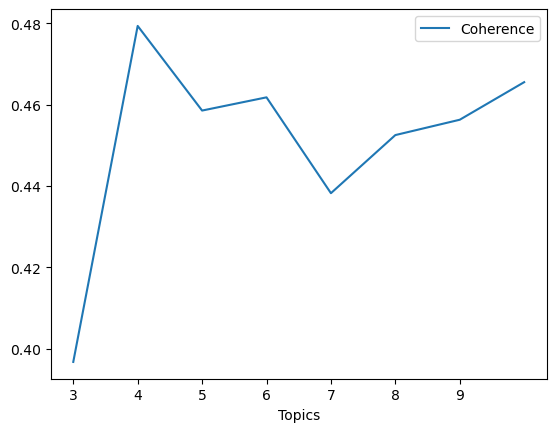

In [33]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(3,10))


##### Best model

In [37]:
%%time

lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)
tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))
tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()

tuned_lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=123,
                       passes=20,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)


CPU times: user 11min 17s, sys: 3min 5s, total: 14min 22s
Wall time: 15min 48s


In [38]:
print(*tuned_lda_model.print_topics(num_topics=4, num_words=5), sep='\n')


(0, '0.038*"market" + 0.013*"intelligence" + 0.012*"artificial" + 0.012*"report" + 0.010*"global"')
(1, '0.020*"ai" + 0.009*"data" + 0.006*"technology" + 0.005*"company" + 0.005*"new"')
(2, '0.009*"ai" + 0.009*"news" + 0.006*"u" + 0.006*"new" + 0.004*"2023"')
(3, '0.013*"news" + 0.010*"business" + 0.010*"service" + 0.009*"product" + 0.008*"technology"')


In [67]:
LDA_plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.119313  0.118971       1        1  40.534561
1      0.055850  0.018976       2        1  33.296772
0      0.033956 -0.181434       3        1  19.317945
3     -0.209119  0.043486       4        1   6.850722, topic_info=         Term           Freq         Total Category  logprob  loglift
322    market  750603.000000  7.506030e+05  Default  30.0000  30.0000
357      news  647344.000000  6.473440e+05  Default  29.0000  29.0000
447    report  315665.000000  3.156650e+05  Default  28.0000  28.0000
89   business  379661.000000  3.796610e+05  Default  27.0000  27.0000
484   service  290187.000000  2.901870e+05  Default  26.0000  26.0000
..        ...            ...           ...      ...      ...      ...
387    people   30480.778999  1.631671e+05   Topic4  -5.4142   1.0031
122  computer   26491.671931  1.069330e+05   Topic4  -5.5545   1.2854
271  industry   29342.648357  2.540841e+05   Topic4  -5.4522   0.5222
553         u   30965.905026  5.150834e+05   Topic4  -5.3984  -0.1306
34         ai   32651.327262  1.217850e+06   Topic4  -5.3454  -0.9381

[406 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8834       2  0.970974  20022022
8834       3  0.028905  20022022
591        2  0.984401  20022023
591        3  0.015538  20022023
13442      3  0.999694  20152020
...      ...       ...       ...
45895      3  0.999489     zacks
54604      1  0.002909     zdnet
54604      2  0.997071     zdnet
5260       4  0.999753     česko
5261       4  0.999782    россия

[931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [55]:
LDA_plot = pyLDAvis.gensim.prepare(tuned_lda_model, corpus, dictionary)

LDA_plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.119313  0.118971       1        1  40.534561
1      0.055850  0.018976       2        1  33.296772
0      0.033956 -0.181434       3        1  19.317945
3     -0.209119  0.043486       4        1   6.850722, topic_info=         Term           Freq         Total Category  logprob  loglift
322    market  750603.000000  7.506030e+05  Default  30.0000  30.0000
357      news  647344.000000  6.473440e+05  Default  29.0000  29.0000
447    report  315665.000000  3.156650e+05  Default  28.0000  28.0000
89   business  379661.000000  3.796610e+05  Default  27.0000  27.0000
484   service  290187.000000  2.901870e+05  Default  26.0000  26.0000
..        ...            ...           ...      ...      ...      ...
387    people   30480.778999  1.631671e+05   Topic4  -5.4142   1.0031
122  computer   26491.671931  1.069330e+05   Topic4  -5.5545   1.2854
271  industry   29342.648357  2.540841e+05   Topic4  -5.4522   0.5222
553         u   30965.905026  5.150834e+05   Topic4  -5.3984  -0.1306
34         ai   32651.327262  1.217850e+06   Topic4  -5.3454  -0.9381

[406 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8834       2  0.970974  20022022
8834       3  0.028905  20022022
591        2  0.984401  20022023
591        3  0.015538  20022023
13442      3  0.999694  20152020
...      ...       ...       ...
45895      3  0.999489     zacks
54604      1  0.002909     zdnet
54604      2  0.997071     zdnet
5260       4  0.999753     česko
5261       4  0.999782    россия

[931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])